In [28]:
import torch 
from torch.utils.data import Dataset, DataLoader 
import joblib

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm 

In [2]:
import torch.nn as nn
import torch.optim as optim

In [3]:
from utils.loss_func import CustomFocalLoss
from utils.metrics import ClassBasedAccuracy
from utils.plot import plot_data_distribution
from utils.preprocess_data_KDD_plus_test import preprocess_data

In [4]:
# # Uncomment the following to create a new preprocessing pipeline for the first time
# pipeline = joblib.load("preprocessing_pipeline/pipeline.pkl")
# label_encoder = joblib.load("preprocessing_pipeline/attack_label_encoder.pkl")

In [5]:
class IntrusionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]
        sample = torch.tensor(sample, dtype = torch.float32)
        sample = sample.unsqueeze(0) # Add a channel dimension [1, 16] & after dataloader [batch size, 1, 16]
        return sample, torch.tensor(label, dtype=torch.long)
        # Pytorch expects labels to be in torch.long format and float32 for features simply because of memory efficiency

In [6]:
# Specify file paths
train_file_path = os.path.join('data', 'train_split.csv')
val_file_path = os.path.join('data', 'valid_split.csv')
test_file_path = os.path.join('data', 'test_split.csv')

preprocessing_models_folder = os.path.join('preprocessing_pipeline')

# Load datasets
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(
    train_file_path=train_file_path,
    val_file_path=val_file_path,
    test_file_path=test_file_path,
    preprocessing_models_folder=preprocessing_models_folder
)


In [7]:
X_train.shape, X_val.shape, X_test.shape

((118315, 16), (14789, 16), (14790, 16))

In [8]:
y_train.shape, y_val.shape, y_test.shape

((118315,), (14789,), (14790,))

In [9]:
X_train[0], y_train[0]

(array([ 1.98644883, -0.86532665,  0.47526487, -1.00654487,  0.69387046,
         0.52524963, -0.2053507 ,  0.00220931, -0.04360147,  0.29817474,
        -0.48461176,  0.32805525,  0.09835973,  0.04107148,  0.62991672,
         0.30032341]),
 np.int64(4))

In [10]:
type(X_train)

numpy.ndarray

Saved distribution plot as img/data_dist_KDD_7.png


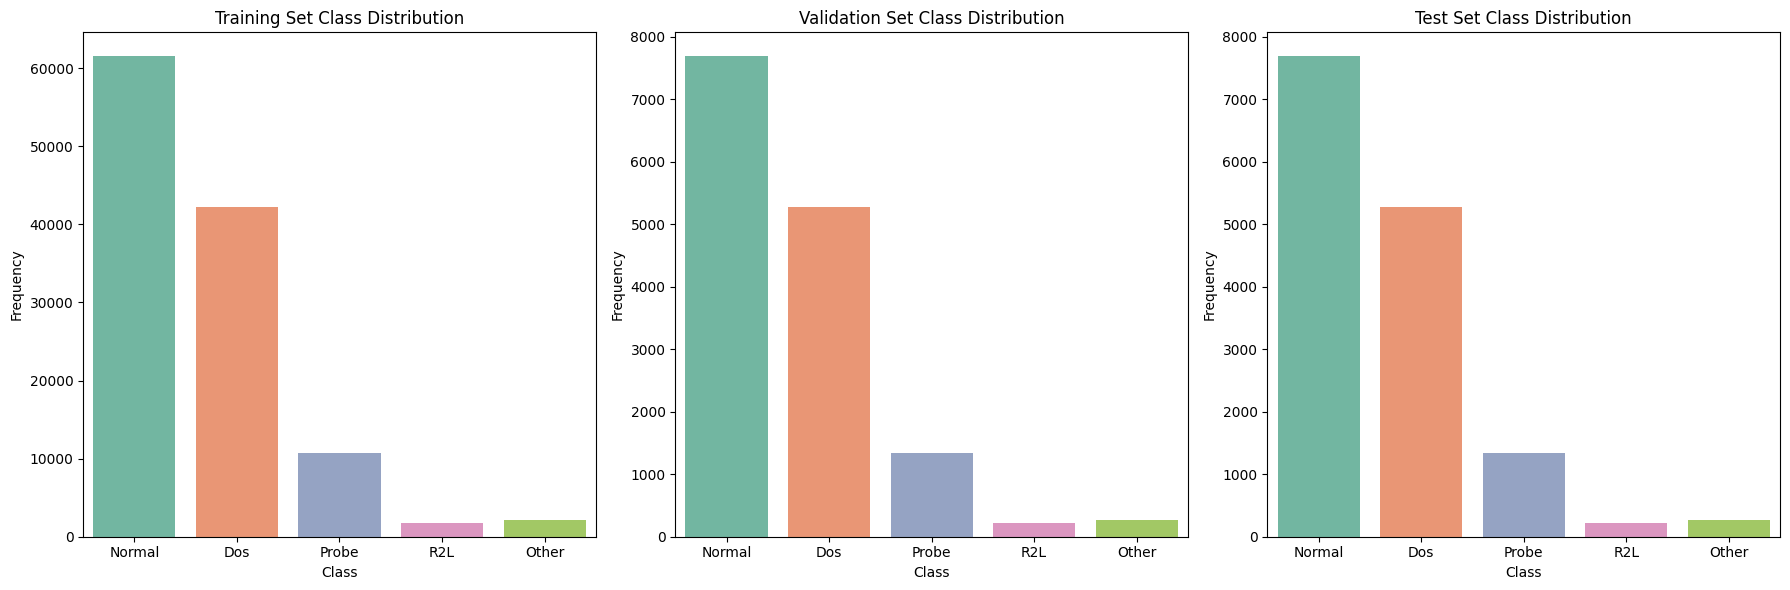

In [11]:
lookup = {0:"Dos", 1:"Other", 2:"Probe", 3:"R2L", 4:"Normal"}
plot_data_distribution(y_train, y_val, y_test, out_path="img", lookup=lookup)

In [12]:
class_counts = {}
for label in y_train:
    class_counts[label]=class_counts.get(label, 0)+1

lookup = {0:"Dos", 1:"Other", 2:"Probe", 3:"R2L", 4:"Normal"}
class_counts_labeled = {lookup.get(k, k): v for k, v in class_counts.items()}
# print(class_counts_labeled)
# plt.figure(figsize=(10,6))
# plt.bar(class_counts_labeled.keys(), class_counts_labeled.values())
# plt.title('Distribution of classes in testing data')
# plt.xlabel('Class labels')
# plt.ylabel('Number of samples')
# plt.xticks()
# plt.show()

In [13]:
class_counts_labeled

{'Normal': 61500, 'Dos': 42226, 'Probe': 10677, 'R2L': 1795, 'Other': 2117}

In [12]:
train_dataset = IntrusionDataset(X_train, y_train)
val_dataset = IntrusionDataset(X_val, y_val)
test_dataset = IntrusionDataset(X_test, y_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [15]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([1, 16]), torch.Size([]))

In [16]:
train_dataset[0]

(tensor([[ 1.9864, -0.8653,  0.4753, -1.0065,  0.6939,  0.5252, -0.2054,  0.0022,
          -0.0436,  0.2982, -0.4846,  0.3281,  0.0984,  0.0411,  0.6299,  0.3003]]),
 tensor(4))

In [17]:
next(iter(train_loader))

[tensor([[[ 2.0137e+00, -8.6454e-01,  1.9094e-01, -1.0261e+00,  8.1279e-01,
            5.6191e-01, -1.9377e-01, -2.0112e-03, -4.5971e-02,  3.0852e-01,
           -5.1259e-01,  3.2837e-01,  1.7000e-01,  7.7244e-03,  7.0947e-01,
            3.1659e-01]],
 
         [[ 2.7159e+00, -9.4909e-01, -8.5552e-01, -4.1980e-01, -1.6106e-01,
           -2.1392e-01, -1.3115e-01, -6.1326e-03, -1.7879e-02, -2.5298e-02,
            1.1568e-01, -4.2268e-01, -9.0537e-01,  1.4364e-01, -3.2748e-01,
            1.7486e-01]],
 
         [[ 2.3681e+00, -9.1658e-01, -3.0783e-01, -8.7597e-01,  4.2611e-01,
            2.6212e-01, -1.8265e-01,  1.1631e-03, -2.3451e-02,  1.7666e-01,
           -2.7943e-01, -4.7017e-01, -5.5982e-01,  9.0558e-02, -1.2876e-01,
            1.8441e-01]],
 
         [[-2.7513e+00, -1.3857e-02, -9.4732e-01,  4.0479e+00,  4.2888e-01,
            1.1461e-01, -4.7728e-01,  2.2021e-02, -1.2154e-01, -2.1121e-01,
           -7.6427e-01, -1.4682e+00,  2.4041e-01,  3.2525e+00,  2.4106e+00,
    

We will implement the following CNN architecture from the paper:

"Effectiveness of Focal Loss for Minority Classification in Network Intrusion Detection Systems"
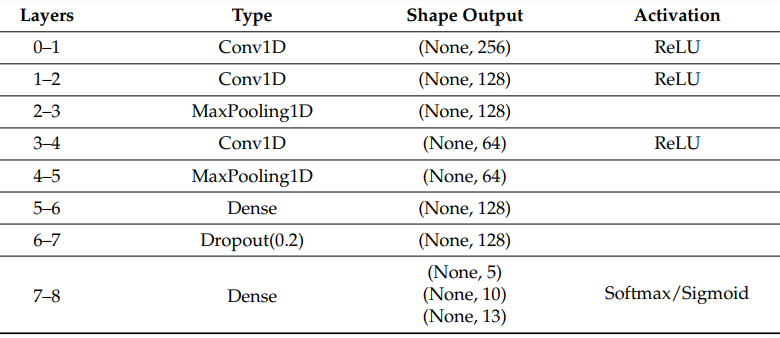

In [20]:
class CustomCNN(nn.Module):
    def __init__(self, output_classes, input_length = 16):
        super().__init__()

        # Conv1D -> (None, 256)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        
        # Conv1D -> (None, 128)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        
        # MaxPooling1D -> (None, 128)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Conv1D -> (None, 64)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        
        # MaxPooling1D -> (None, 64)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Dense -> (None, 128)
        self.fc1 = nn.Linear(64 * input_length // 4, 128)  # Adjust input size based on pooling
        self.relu4 = nn.ReLU()
        
        # Dropout -> (None, 128)
        self.dropout = nn.Dropout(0.2)
        
        # Output layer(s)
        self.fc2 = nn.Linear(128, output_classes)  # Final dense layer
        
    def forward(self, x):
        # Pass through Conv1D layers
        # print(f"Input shape: {x.shape}")
        x = self.relu1(self.conv1(x))
        # print(f"After conv1: {x.shape}")
        x = self.relu2(self.conv2(x))
        # print(f"After conv2: {x.shape}")
        x = self.pool1(x)
        # print(f"After pool1: {x.shape}")
        x = self.relu3(self.conv3(x))
        # print(f"After conv3: {x.shape}")
        x = self.pool2(x)
        # print(f"After pool2: {x.shape}")
        
        # Flatten before passing into Dense layers
        x = x.view(x.size(0), -1)
        # print(f"After flatten: {x.shape}")
        
        # Fully connected layers
        x = self.relu4(self.fc1(x))
        # print(f"After fc1: {x.shape}")
        x = self.dropout(x)
        # print(f"After dropout: {x.shape}")
        x = self.fc2(x)
        # print(f"After fc2 (output): {x.shape}")
        
        return x

In [19]:
out_classes = 5
model = CustomCNN(out_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
def compute_inverse_freq_weights(labels, num_classes):
    """
    Compute inverse frequency weights for each class using a mask.
    
    Args:
    - labels (np.ndarray): A NumPy array of shape (N,) containing class labels.
    - num_classes (int): The total number of classes.
    
    Returns:
    - torch.Tensor: A tensor containing normalized inverse frequency weights for each class.
    """
    # Convert labels to a torch tensor
    labels = torch.tensor(labels, dtype=torch.long)

    # Compute class counts (ensures all classes are considered)
    class_counts = torch.bincount(labels, minlength=num_classes)

    print(class_counts)

    # Create a mask to avoid division by zero
    mask = class_counts > 0

    # Compute inverse frequency weights (handling missing classes)
    total_samples = len(labels)
    inverse_freq_weights = torch.zeros(num_classes, dtype=torch.float32)
    inverse_freq_weights[mask] = total_samples / class_counts[mask]

    # Normalize so the mean weight is 1 (not sum up to 1 so that there are no extreme values)
    inverse_freq_weights *= num_classes / inverse_freq_weights.sum()

    # # Normalize so weights sum to 1
    # inverse_freq_weights /= inverse_freq_weights.sum()

    return inverse_freq_weights


In [ ]:
alpha = compute_inverse_freq_weights(y_train, 5)

In [16]:
alpha

tensor([0.1018, 2.0307, 0.4026, 2.3950, 0.0699])

In [24]:
X, y = next(iter(train_loader))

In [25]:
X.shape, y.shape

(torch.Size([32, 1, 16]), torch.Size([32]))

In [26]:
custom_loss_fn = CustomFocalLoss(alpha=alpha)

In [28]:

len(train_loader)

3698

In [29]:
len(train_dataset)

118315

In [30]:
# metric = ClassBasedAccuracy(num_classes=5)

# for x_batch, y_batch in train_loader:
#     x_batch = x_batch.to("cuda")
#     y_batch = y_batch.to("cuda")
#     y_pred = model(x_batch)
#     y_pred = y_pred.to("cuda")
#     class_acc = metric(y_batch, y_pred.argmax(dim=-1))  # Ensure no accidental reduction
#     print(class_acc)

In [17]:
from torch.utils.tensorboard import SummaryWriter

class TensorBoardLogger:
    def __init__(self, log_dir='runs', class_names=None):
        self.writer = SummaryWriter(log_dir)
        self.class_names = class_names or {}

    def log_epoch(self, epoch, per_class_acc, per_class_loss, overall_acc, phase='train'):
        # Add phase prefix to distinguish between train/val/test
        prefix = f'{phase}/'
        
        # Log per class accuracies
        for i, acc in enumerate(per_class_acc):
            class_label = self.class_names.get(i, f'Class_{i}')
            self.writer.add_scalar(f'{prefix}Per Class Accuracy/{class_label}', acc, epoch)
        
        # Log per class losses
        for i, loss in enumerate(per_class_loss):
            class_label = self.class_names.get(i, f'Class_{i}')
            self.writer.add_scalar(f'{prefix}Per Class Loss/{class_label}', loss, epoch)
        
        # Log overall accuracy
        self.writer.add_scalar(f'{prefix}Overall Accuracy', overall_acc, epoch)


    def log_test(self, per_class_acc, avg_loss, overall_acc):
        prefix = 'test/'

        # Log per-class accuracies
        for i, acc in enumerate(per_class_acc):
            class_label = self.class_names.get(i, f'Class_{i}')
            self.writer.add_scalar(f'{prefix}Per Class Accuracy/{class_label}', acc)

        # Log overall accuracy and loss
        self.writer.add_scalar(f'{prefix}Average Loss', avg_loss)
        self.writer.add_scalar(f'{prefix}Overall Accuracy', overall_acc)

    def close(self):
        self.writer.close()
# Usage
lookup = {0:"Dos", 1:"Other", 2:"Probe", 3:"R2L", 4:"Normal"}
tensorboard_logger = TensorBoardLogger(log_dir='tensorboard_logs', class_names=lookup)

In [34]:
def train_and_validate_epoch(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    custom_loss_fn, 
    device, 
    num_classes, 
    epoch, 
    num_epochs, 
    tensorboard_logger=None
):
    # Training phase
    train_class_accuracy = ClassBasedAccuracy(num_classes=num_classes)
    model.train()
    train_class_accuracy.reset()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(train_loader, 
                         desc=f"Epoch: {epoch + 1}/{num_epochs}", 
                         leave=False, 
                         ncols=120)

    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = custom_loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)

        train_class_accuracy.update_state(labels, predicted)
        running_loss += loss.item()
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        progress_bar.set_postfix(
            batch=f"[{i + 1}/{len(train_loader)}]", 
            loss=f"{loss.item():.4f}", 
            overall_acc=f"{100.0 * total_correct / total_samples:.2f}%"
        )

    # Training metrics
    train_class_acc = train_class_accuracy.compute()
    train_overall_acc = 100.0 * total_correct / total_samples
    # train_avg_class_acc = train_class_acc.mean().item()
    avg_loss = running_loss / len(train_loader)

    if tensorboard_logger:
        tensorboard_logger.log_epoch(
            epoch,
            per_class_acc=train_class_acc.cpu().numpy(),
            per_class_loss=[running_loss / len(train_loader)],
            overall_acc=train_overall_acc,
            train_loss_per_epoch = avg_loss
        )

    # Validation phase
    val_class_accuracy = ClassBasedAccuracy(num_classes=num_classes)
    model.eval()
    val_class_accuracy.reset()
    val_running_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = custom_loss_fn(outputs, labels)

            _, predicted = torch.max(outputs, 1)

            val_class_accuracy.update_state(labels, predicted)
            val_running_loss += loss.item()
            val_total_correct += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)

    # Validation metrics
    val_class_acc = val_class_accuracy.compute()
    val_overall_acc = 100.0 * val_total_correct / val_total_samples
    # val_avg_class_acc = val_class_acc.mean().item()
    val_avg_loss = val_running_loss/len(val_loader)
    if tensorboard_logger:
        tensorboard_logger.log_epoch(
            epoch,
            per_class_acc=val_class_acc.cpu().numpy(),
            per_class_loss=[val_running_loss / len(val_loader)],
            overall_acc=val_overall_acc,
            val_loss_per_epoch = val_avg_loss
        )

    # Print epoch summary
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print(f"Training   - Overall Accuracy: {train_overall_acc:.2f}%")
    print(f"Training   - Per Class Accuracies: {train_class_acc.cpu().numpy()}")
    # print(f"Training   - Avg Class Accuracy: {train_avg_class_acc100:.2f}%")
    print(f"Validation - Overall Accuracy: {val_overall_acc:.2f}%")
    print(f"Validation - Per Class Accuracies: {val_class_acc.cpu().numpy()}")
    # print(f"Validation - Avg Class Accuracy: {val_avg_class_acc100:.2f}%")

    return model

In [35]:
lookup = {0:"Dos", 1:"Other", 2:"Probe", 3:"R2L", 4:"Normal"}
tensorboard_logger = TensorBoardLogger(log_dir='tensorboard_logs', class_names=lookup)

num_epochs = 15
num_classes = 5
for epoch in range(num_epochs):
    trained_model = train_and_validate_epoch(
        model, 
        train_loader, 
        val_loader, 
        optimizer, 
        custom_loss_fn, 
        device, 
        num_classes, 
        epoch, 
        num_epochs,
        tensorboard_logger
    )
tensorboard_logger.close()


Epoch 1/15
Training   - Overall Accuracy: 88.55%
Training   - Per Class Accuracies: [0.9591484  0.77326405 0.9547626  0.80891365 0.8290244 ]
Validation - Overall Accuracy: 90.32%
Validation - Per Class Accuracies: [0.97442216 0.8        0.96476763 0.8977778  0.8474047 ]



Epoch 2/15
Training   - Overall Accuracy: 89.82%
Training   - Per Class Accuracies: [0.9670345  0.79641    0.96328557 0.8178273  0.84539837]
Validation - Overall Accuracy: 89.74%
Validation - Per Class Accuracies: [0.97139066 0.66415095 0.97526234 0.94222224 0.8397294 ]



Epoch 3/15
Training   - Overall Accuracy: 90.68%
Training   - Per Class Accuracies: [0.96978164 0.8068021  0.96693826 0.8395543  0.8585529 ]
Validation - Overall Accuracy: 90.22%
Validation - Per Class Accuracies: [0.9823797  0.8566038  0.9722639  0.80444443 0.83946925]



Epoch 4/15
Training   - Overall Accuracy: 91.26%
Training   - Per Class Accuracies: [0.97366554 0.83278227 0.97021633 0.84568244 0.86530083]
Validation - Overall Accuracy: 92.86%
Validation - Per Class Accuracies: [0.9895794  0.78867924 0.98275864 0.94222224 0.8817484 ]



Epoch 5/15
Training   - Overall Accuracy: 91.87%
Training   - Per Class Accuracies: [0.97705203 0.844119   0.9704973  0.8523677  0.8741301 ]
Validation - Overall Accuracy: 93.39%
Validation - Per Class Accuracies: [0.9742327  0.8301887  0.9790105  0.83111113 0.90490437]



Epoch 6/15
Training   - Overall Accuracy: 91.63%
Training   - Per Class Accuracies: [0.9738787  0.8431743  0.9704037  0.8557103  0.87165856]
Validation - Overall Accuracy: 91.06%
Validation - Per Class Accuracies: [0.9816218  0.79622644 0.98125935 0.8933333  0.8540393 ]



Epoch 7/15
Training   - Overall Accuracy: 92.32%
Training   - Per Class Accuracies: [0.9771468  0.8516769  0.97415006 0.865181   0.8814309 ]
Validation - Overall Accuracy: 93.52%
Validation - Per Class Accuracies: [0.97934824 0.91320753 0.9835082  0.80444443 0.9010017 ]



Epoch 8/15
Training   - Overall Accuracy: 92.09%
Training   - Per Class Accuracies: [0.9759627  0.86065185 0.97293246 0.8590529  0.87801623]
Validation - Overall Accuracy: 91.22%
Validation - Per Class Accuracies: [0.9730959  0.8603774  0.9722639  0.8488889  0.86366594]



Epoch 9/15
Training   - Overall Accuracy: 92.62%
Training   - Per Class Accuracies: [0.97840196 0.87057155 0.9735881  0.8679666  0.88573986]
Validation - Overall Accuracy: 92.09%
Validation - Per Class Accuracies: [0.9876847  0.8        0.98050976 0.95111114 0.8679589 ]



Epoch 10/15
Training   - Overall Accuracy: 92.80%
Training   - Per Class Accuracies: [0.9791124  0.88049126 0.9745247  0.8807799  0.88780487]
Validation - Overall Accuracy: 92.39%
Validation - Per Class Accuracies: [0.98294806 0.8981132  0.9857571  0.8755556  0.8748537 ]



Epoch 11/15
Training   - Overall Accuracy: 92.93%
Training   - Per Class Accuracies: [0.97863877 0.88757676 0.9728388  0.88133705 0.89066666]
Validation - Overall Accuracy: 93.60%
Validation - Per Class Accuracies: [0.97821146 0.89056605 0.9775112  0.84444445 0.90412384]



Epoch 12/15
Training   - Overall Accuracy: 92.82%
Training   - Per Class Accuracies: [0.97946763 0.88615966 0.97293246 0.88579386 0.88796747]
Validation - Overall Accuracy: 92.41%
Validation - Per Class Accuracies: [0.9910951  0.8        0.9730135  0.8577778  0.87589437]



Epoch 13/15
Training   - Overall Accuracy: 92.96%
Training   - Per Class Accuracies: [0.9793966  0.88190836 0.9746183  0.87743735 0.89066666]
Validation - Overall Accuracy: 94.25%
Validation - Per Class Accuracies: [0.9886321  0.7358491  0.9835082  0.97333336 0.9098478 ]



Epoch 14/15
Training   - Overall Accuracy: 92.88%
Training   - Per Class Accuracies: [0.978544   0.8937175  0.9737754  0.88133705 0.8893496 ]
Validation - Overall Accuracy: 91.95%
Validation - Per Class Accuracies: [0.98029554 0.84150946 0.9797601  0.94666666 0.8691297 ]



Epoch 15/15
Training   - Overall Accuracy: 92.72%
Training   - Per Class Accuracies: [0.9777625  0.88049126 0.9739627  0.87966573 0.8873659 ]
Validation - Overall Accuracy: 93.35%
Validation - Per Class Accuracies: [0.98635846 0.83773583 0.95277363 0.93333334 0.8972291 ]


In [36]:
torch.save(trained_model.state_dict(), "CNN_15_epochs.pth")

In [22]:
len(test_loader)

463

In [23]:
len(train_loader)

3698

In [24]:
len(train_dataset)

118315

In [25]:
118315/32

3697.34375

In [ ]:
# metric = ClassBasedAccuracy(num_classes=10)

# # In training loop
# y_true = torch.tensor([0, 1, 2, 0, 1])
# y_pred = torch.tensor([0, 2, 2, 1, 1])

# # Compute class-based accuracy
# class_accuracies = metric(y_true, y_pred)
# print(class_accuracies)  # 

In [ ]:
!tensorboard --logdir="/home/mejan/projects/intrusion/Network_Intrusion_detection/tensorboard_logs"

In [31]:
def testing_func(model, test_loader, device, custom_loss_fn, tensorboard_logger=None, num_classes = 5):
    test_class_accuracy = ClassBasedAccuracy(num_classes=num_classes)
    test_class_accuracy.reset()
    test_running_loss = 0.0
    test_total_correct = 0
    test_total_samples = 0 

    all_preds = []
    all_labels = []

    model.eval()
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = custom_loss_fn(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            test_class_accuracy.update_state(labels, predicted)
            test_running_loss += loss.item()
            test_total_correct += (predicted == labels).sum().item()
            test_total_samples += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_class_acc = test_class_accuracy.compute()
    test_overall_acc = 100.0 * test_total_correct / test_total_samples
    avg_loss = test_running_loss / len(test_loader)

    if tensorboard_logger:
        tensorboard_logger.log_test(
            per_class_acc=test_class_acc.cpu().numpy(),
            avg_loss=avg_loss,
            overall_acc=test_overall_acc
        )

    print(f"\nTest Results:")
    print(f"Overall Accuracy: {test_overall_acc:.2f}%")
    print(f"Per Class Accuracies: {test_class_acc.cpu().numpy()}")
    print(f"Average Loss: {avg_loss:.4f}")

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[lookup[i] for i in range(len(lookup))],  # Using class names as x-ticks
            yticklabels=[lookup[i] for i in range(len(lookup))])  # Using class names as y-ticks
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    # print("Classification Report:\n", classification_report(all_labels, all_preds))
    print("Classification report:\n", classification_report(all_labels, all_preds, target_names=[lookup[i] for i in range(len(lookup))]))
    return {
        "test_acc": test_overall_acc,
        "per_class": test_class_acc,
        "loss": avg_loss,
        "y_preds":all_preds,
        "y_true":all_labels
    }


/tmp/ipykernel_513006/2518147578.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_for_test.load_state_dict(torch.load("CNN_15_epochs.pth"))
Testing: 100%|██████████


Test Results:
Overall Accuracy: 93.02%
Per Class Accuracies: [0.98465616 0.79545456 0.96104866 0.95535713 0.89125913]
Average Loss: 0.0150


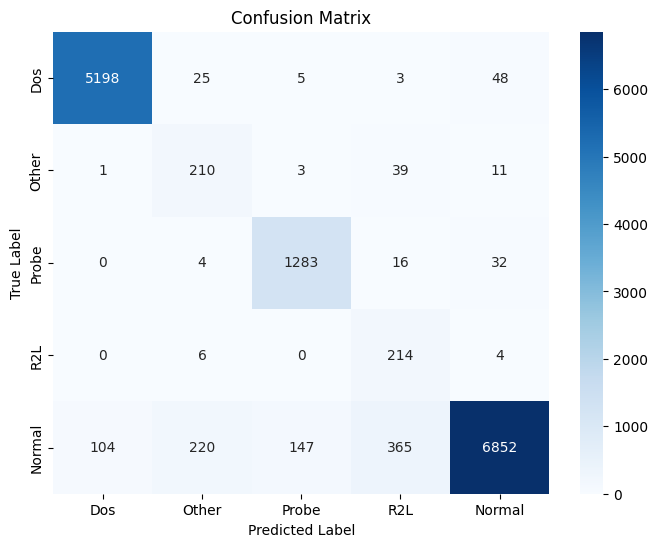

Classification report:               precision    recall  f1-score   support

         Dos       0.98      0.98      0.98      5279
       Other       0.45      0.80      0.58       264
       Probe       0.89      0.96      0.93      1335
         R2L       0.34      0.96      0.50       224
      Normal       0.99      0.89      0.94      7688

    accuracy                           0.93     14790
   macro avg       0.73      0.92      0.78     14790
weighted avg       0.96      0.93      0.94     14790



In [32]:
device = torch.device("cuda")

tensorboard_logger = TensorBoardLogger(log_dir="runs/test_logs", class_names={0: "Class_A", 1: "Class_B", 2: "Class_C"})

model_for_test = CustomCNN(output_classes=5).to(device)
model_for_test.load_state_dict(torch.load("CNN_15_epochs.pth"))

custom_loss_fn = custom_loss_fn = CustomFocalLoss(alpha=alpha)
# Run Test Loop

results = testing_func(model_for_test, test_loader, device, custom_loss_fn, tensorboard_logger)